Zero-Shot Image Classification using CLIP

In [1]:
#Import necessary libraries
from PIL import Image #Used for image processing
import requests
from transformers import CLIPProcessor, CLIPModel
import torch

from IPython.display import display

In [2]:
#Load the model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

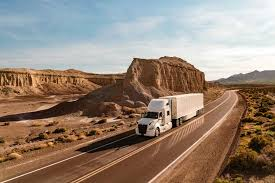

In [4]:
#Load images
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSE8VtiHOV83NmayqkYZW4oQ_7FhiwMqVcPaA&s"
image = Image.open(requests.get(url, stream=True).raw)

display(image)

In [5]:
# Define the list of target labels/categrories
text = ["car", "truck", "bus", "cycle"]

In [6]:
#Preprocess the text and image using the CLIP processor, return_tensors="pt" specifies to return PyTorch tensors
#padding=True ensures inputs are padded to the same length
inputs = processor(text=text, images=image, return_tensors="pt", padding=True)

In [7]:
# Unpack the inputs
input_ids = inputs.input_ids
print("Input IDs (shape):", input_ids.shape)
print(input_ids)

Input IDs (shape): torch.Size([4, 3])
tensor([[49406,  1615, 49407],
        [49406,  4629, 49407],
        [49406,  2840, 49407],
        [49406,  5072, 49407]])


inputs.attention_mask
This is a binary mask used to indicate which tokens in the input_ids are actual words and which are padding tokens. It helps the model to focus on the relevant parts of the input sequence. Values of 1 indicate valid tokens, and values of 0 indicate padding.

In [8]:
attention_mask = inputs.attention_mask
print("Attention Mask (shape):", attention_mask.shape)
print(attention_mask)

Attention Mask (shape): torch.Size([4, 3])
tensor([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]])


In [10]:
pixel_values = inputs.pixel_values
print("Pixel Values (shape):", pixel_values.shape)
print(pixel_values)

Pixel Values (shape): torch.Size([1, 3, 224, 224])
tensor([[[[ 0.3099,  0.3099,  0.2953,  ...,  1.0982,  1.0982,  1.1128],
          [ 0.2369,  0.2369,  0.2369,  ...,  1.1128,  1.1128,  1.1128],
          [ 0.1347,  0.1347,  0.1493,  ...,  1.1128,  1.1128,  1.1128],
          ...,
          [-0.0113, -0.0113,  0.0471,  ...,  0.6165,  0.3829, -0.0988],
          [ 0.0471,  0.0617,  0.1055,  ...,  0.4851,  0.5143,  0.0179],
          [ 0.0909,  0.1055,  0.1493,  ..., -0.2886,  0.0033,  0.0471]],

         [[ 0.8593,  0.8893,  0.8593,  ...,  1.5646,  1.5646,  1.5796],
          [ 0.7842,  0.8142,  0.8142,  ...,  1.5796,  1.5796,  1.5796],
          [ 0.6792,  0.6942,  0.7242,  ...,  1.5946,  1.5946,  1.5946],
          ...,
          [-0.4614, -0.4614, -0.4014,  ...,  0.2439,  0.0038, -0.4914],
          [-0.4014, -0.3864, -0.3414,  ...,  0.1239,  0.1539, -0.3414],
          [-0.3564, -0.3414, -0.2963,  ..., -0.6715, -0.3564, -0.3114]],

         [[ 1.3638,  1.3780,  1.3638,  ...,  1.7477

In [15]:
# Ensure no gradients are calculated for faster inference
with torch.no_grad():
  outputs = model(**inputs)
print(outputs.text_embeds.shape)
print(outputs.image_embeds.shape)
logits_per_image = outputs.logits_per_image
print("logits per image (shape):", logits_per_image.shape)
print(logits_per_image)

# temperature multiplier
temperature = model.logit_scale.exp().item()
print(f"Cosine similarity is scaled by: {temperature:.3f}")


torch.Size([4, 512])
torch.Size([1, 512])
logits per image (shape): torch.Size([1, 4])
tensor([[20.3438, 25.5131, 20.0962, 17.9956]])
Cosine similarity is scaled by: 100.000


In [16]:
probs = logits_per_image.softmax(dim=-1) # Apply Softmax to get probabilities

In [17]:
# Print the probabilities for each class
for i, label in enumerate(text):
  print(f"Probability of {label}: {probs[0][i].item()}")
predicted_label = text[probs.argmax()]
print(f"\n Predicted Label: {predicted_label}")

Probability of car: 0.005628455430269241
Probability of truck: 0.9894397854804993
Probability of bus: 0.004394009709358215
Probability of cycle: 0.0005377031047828496

 Predicted Label: truck
